In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

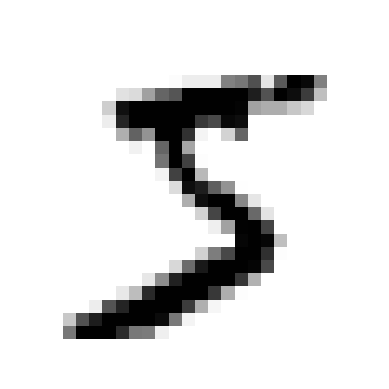

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0]  # fix: use iloc
some_digit_image = some_digit.values.reshape(28, 28)  # fix: use .values to get raw pixel array

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()


In [6]:
y[0]

'5'

In [7]:
import numpy  as np
y = y.astype(np.uint8)

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [10]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [11]:
sgd_clf.predict([some_digit])

C:\Users\chala\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)

    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.9669
0.91625
0.96785


In [13]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [14]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros(len(X), dtype=bool)  # fix shape

# assume X_train is loaded and y_train_5 = (y_train == 5)
scores = cross_val_score(Never5Classifier(), X_train, y_train_5, cv=3, scoring="accuracy")
print(scores)


[0.91125 0.90855 0.90915]


In [15]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [17]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [18]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 4096 / (4096 + 1522)
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [19]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

C:\Users\chala\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [20]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [21]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
method="decision_function")

In [23]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

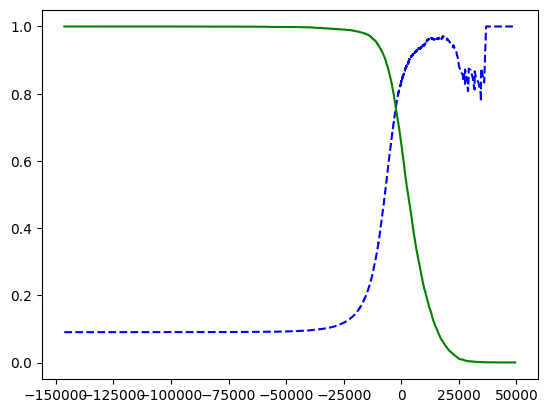

In [24]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
 plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
 plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [25]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

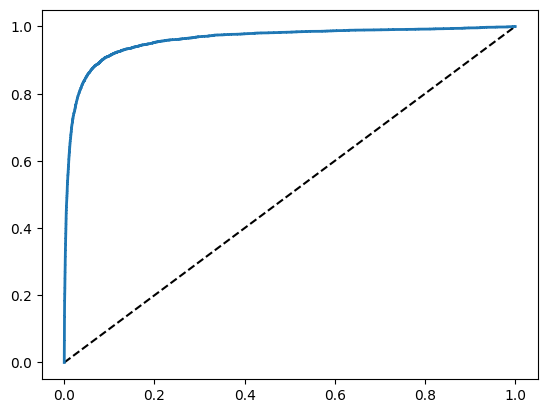

In [26]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal

plot_roc_curve(fpr, tpr)
plt.show()

In [27]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

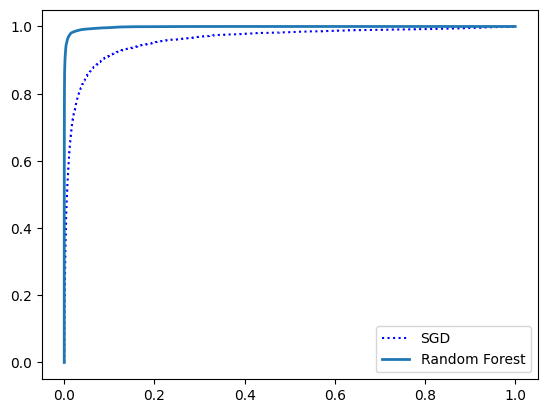

In [28]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [29]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [30]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train) # y_train, not y_train_5
svm_clf.predict([some_digit])

C:\Users\chala\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [31]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

C:\Users\chala\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [32]:
np.argmax(some_digit_scores)
svm_clf.classes_
svm_clf.classes_[5]

np.uint8(5)

In [33]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)

C:\Users\chala\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\chala\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\chala\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\chala\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\chala\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.w

10

In [34]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])
sgd_clf.decision_function([some_digit])

C:\Users\chala\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(
C:\Users\chala\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [35]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [36]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [37]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

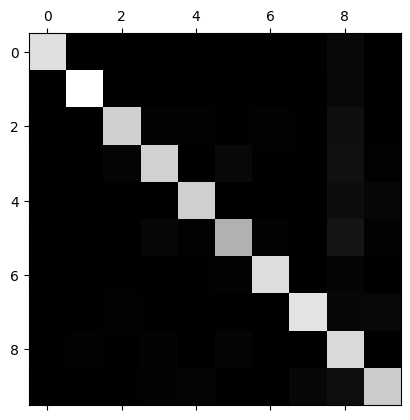

In [38]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

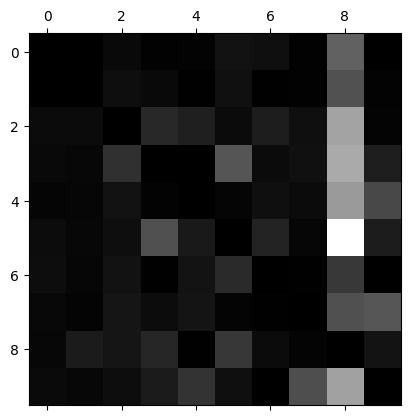

In [39]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

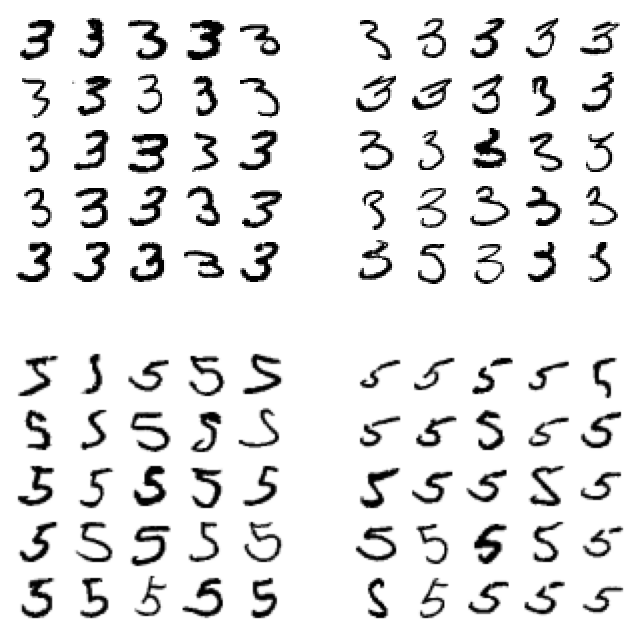

In [41]:
def plot_digits(instances, images_per_row=10, **options):
    import matplotlib.pyplot as plt
    import numpy as np

    size = 28  # assuming MNIST images are 28x28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1
    n_empty = n_rows * images_per_row - len(instances)
    padded = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)
    image_grid = padded.reshape((n_rows, images_per_row, size, size)) \
                       .swapaxes(1, 2) \
                       .reshape((n_rows * size, images_per_row * size))
    plt.imshow(image_grid, cmap=plt.cm.binary, **options)
    plt.axis("off")


cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([some_digit])

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

C:\Users\chala\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


0.9764102655606048

In [44]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

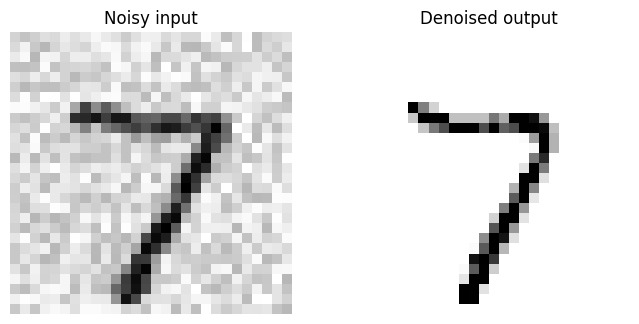

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

# STEP 1: Add noise to training and test data
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = np.array(X_train) + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = np.array(X_test) + noise

# STEP 2: Convert to NumPy array in case X_train and X_test are pandas DataFrames
X_train_mod = np.array(X_train_mod)
y_train_mod = np.array(X_train)
X_test_mod = np.array(X_test_mod)
y_test_mod = np.array(X_test)

# STEP 3: Train the KNN classifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)

# STEP 4: Pick one noisy test digit and denoise it
some_index = 0  # Change to see other test digits
noisy_digit = X_test_mod[some_index]
clean_digit = knn_clf.predict([noisy_digit])

# STEP 5: Define plotting function
def plot_digit(image, title=""):
    image = image.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")
    if title:
        plt.title(title)

# STEP 6: Plot the noisy input and denoised output side by side
plt.figure(figsize=(8, 4))
plt.subplot(121)
plot_digit(noisy_digit, "Noisy input")
plt.subplot(122)
plot_digit(clean_digit, "Denoised output")
plt.show()
